# IRWA Project Part 1

|Name | Email | UPF uNum |
| --- | --- | --- |
| Clara Pena | clara.pena01@estudiant.upf.edu | u186416 |
| Yuyan Wang | yuyan.wang01@estudiant.upf.edu | u199907 |

## Import Libraries and Load Data

In [1]:
import pandas as pd
import json
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer # Includes support for different sets of stop words and tokenizers that are better suited for languages other than English
import string
import re
import emoji
from langdetect import detect, LangDetectException # To detect different languages
# Another approach could be to use a public API to translate the content from any word to english and to conduct the whole process in english
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from tqdm import tqdm
from collections import Counter
import altair as alt
alt.data_transformers.enable("vegafusion")

DataTransformerRegistry.enable('vegafusion')

In [2]:
# Download NLTK resources
nltk.download('punkt')
# nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/yuyi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/yuyi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Preprocessing

In [3]:
# Languages supported by both SnowballStemmer and Word_tokenize; Otherwise it will give error
lang_map = {'en': 'english', 'es': 'spanish', 'fr': 'french', 'de': 'german', 'da': 'danish', 'nl': 'dutch', 'it': 'italian', 'fi': 'finnish', 'ru': 'russian', 'el': 'greek', 'no': 'norwegian', 'pt': 'portuguese', 'sv': 'swedish'}


In [4]:
def preprocess_text(text, lang_code='en', language_mapping=lang_map):
    # Map language code to SnowballStemmer language name
    language = language_mapping.get(lang_code, 'english')  # Default to 'english' if lang_code is unsupported

    text = text.lower()

    # Remove mentions (anything starting with @ and followed by any characters until a space or end of the string)
    text = re.sub(r'@\w+', '', text)

    # Remove emojis
    text = emoji.replace_emoji(text, replace='')

    # Handle contractions by removing possessive endings and common contractions
    text = re.sub(r"\b(\w+)'s\b", r'\1', text)  # Changes "people's" to "people"
    text = re.sub(r"\b(\w+)n't\b", r'\1 not', text)  # Changes "isn't" to "is not"
    text = re.sub(r"\b(\w+)'ll\b", r'\1 will', text)  # Changes "I'll" to "I will"
    text = re.sub(r"\b(\w+)'d\b", r'\1 would', text)  # Changes "I'd" to "I would"
    text = re.sub(r"\b(\w+)'re\b", r'\1 are', text)  # Changes "you're" to "you are"
    text = re.sub(r"\b(\w+)'ve\b", r'\1 have', text)  # Changes "I've" to "I have"

    tokens = word_tokenize(text, language=language)

    # Remove punctuation
    table = str.maketrans('', '', string.punctuation)
    stripped_tokens = [w.translate(table) for w in tokens]

    # Remove non-alphabetic tokens
    words = [word for word in stripped_tokens if word.isalpha()]

    # Remove stop words for the detected language
    try:
        stop_words = set(stopwords.words(language))
        stop_words.add('https')
    except OSError:
        stop_words = set()
    words = [w for w in words if not w in stop_words]

    # Stemming
    try:
        stemmer = SnowballStemmer(language)
        # stemmed = [stemmer.stem(word) for word in words]
        # stemmer.step("people") gives "peopl" but stemmer.step("people rights") give "people right"
        stemmed = stemmer.stem(' '.join(words))
    except Exception as e:
        print(f"Stemming not performed due to: {e}")
        stemmed = words  # Fallback to non-stemmed words if stemming fails

    return stemmed.split()

In [5]:
def process_tweets(json_file):
    processed_tweets = []

    with open(json_file, 'r') as file:
        total_lines = sum(1 for line in file)

    # Open the file and read it line by line
    with open(json_file, 'r') as file:
        # i = 0
        for line in tqdm(file, total=total_lines, desc="Processing Tweets", unit="tweet"):
            try:
                tweet = json.loads(line)

                # Attempt to detect language
                try:
                    lang = detect(tweet.get('content', ''))
                except LangDetectException:
                    lang = 'unsure'  # Set to 'unsure' if language detection fails

                # print(lang, tweet)

                lang_of_process = 'english' if lang == 'unsure' else lang # Use English as the default language if unsure

                # Process the tweet content
                content = tweet.get('content', '')
                processed_content = preprocess_text(content, lang_code=lang_of_process)

                # Extract hashtags; See next section for reasoning behing this
                hashtags = [word for word in content.split() if word.startswith('#')]

                # Build the processed tweet information
                processed_tweet = {
                    'id': tweet.get('id', None),
                    'content': ' '.join(processed_content),
                    'date': tweet.get('date'),
                    'hashtags': ' '.join(hashtags),
                    'likes': tweet.get('likeCount'),
                    'retweets': tweet.get('retweetCount'),
                    'url': tweet.get('url'),
                    'language': lang  # Store the detected or default language
                }

                processed_tweets.append(processed_tweet)
            except json.JSONDecodeError:
                print(f"Failed to parse line: {line}")
                continue

    return processed_tweets

In [6]:
# Correct path to your JSON file
json_file_path = './data/farmers-protest-tweets.json'
processed_data = process_tweets(json_file_path)

Processing Tweets: 100%|██████████| 117405/117405 [10:25<00:00, 187.56tweet/s]


In [7]:
# Map tweetId with documentId
df = pd.DataFrame(processed_data)
doc_mapping = pd.read_csv('./data/tweet_document_ids_map.csv')

# Merge the processed tweets DataFrame with the document mapping on the 'id' column
df = pd.merge(df, doc_mapping, on='id', how='left')
df.head()

,id,content,date,hashtags,likes,retweets,url,language,docId
0,1364506195453767680,ਆ ਚ farmersprotest,2021-02-24T09:23:22+00:00,#FarmersProtest,0,0,https://twitter.com/parmarmaninder/status/1364...,pa,NaN
1,1364506167226032128,watch full video farmersprotest nofarmersnofoo...,2021-02-24T09:23:16+00:00,#farmersprotest #NoFarmersNoFood,0,0,https://twitter.com/anmoldhaliwal/status/13645...,en,doc_2
2,1364506144002088963,kisanektamorcha farmersprotest nofarmersnofood,2021-02-24T09:23:10+00:00,#KisanEktaMorcha #FarmersProtest #NoFarmersNoFood,0,0,https://twitter.com/KotiaPreet/status/13645061...,en,NaN
3,1364506120497360896,jai jwaan jai kis farmersprotest modiignoringf...,2021-02-24T09:23:05+00:00,#FarmersProtest #ModiIgnoringFarmersDeaths,0,0,https://twitter.com/babli_708/status/136450612...,fi,NaN
4,1364506076272496640,farmersprotest,2021-02-24T09:22:54+00:00,#FarmersProtest,0,0,https://twitter.com/Varinde17354019/status/136...,en,NaN


In [8]:
# Save the data in CSV format
# df.to_csv('processed_data.csv', index=False)

### Dertermining Hashtag Handling

In [9]:
evaluation_gt = pd.read_csv('./data/evaluation_gt.csv', sep=';')
# Merge with processed tweets to see relevance
df_eva = pd.merge(df, evaluation_gt, on='docId', how='left')

pd.set_option('display.max_colwidth', None)

# Analyze hashtags in tweets relevant and irrelevant to query 1
query_1_relevant = df_eva[(df_eva['query_id'] == 1) & (df_eva['label'] == 1)]
print(query_1_relevant['hashtags'], "\n")

query_1_not_relevant = df_eva[(df_eva['query_id'] == 1) & (df_eva['label'] == 0)]
print(query_1_not_relevant['hashtags'])

2503                                                                          #FarmersProtest
4959                                           #farmersprotest #FreeDeepSidhu #freenodeepkaur
7878                                                                          #FarmersProtest
8359                                                                          #FarmersProtest
8695                                                                          #FarmersProtest
9966     #FarmersProtest #Pagdi_Sambhal_Jatta #FarmersStandingFirm #ModiIgnoringFarmersDeaths
12675                                   #democracy #ModiIgnoringFarmersDeaths #FarmersProtest
12737                                 #humanrights #ModiIgnoringFarmersDeaths #FarmersProtest
13335                 #FarmersProtest #HumanRights #ModiIgnoringFarmersDeaths #FarmersProtest
15221                                                                         #FarmersProtest
18663                                                       

The first printed DataFrame represents all the hashtags that are relevant to the query related to the Indian government, while the second DataFrame shows hashtags that are not relevant. From these outputs, we can build several arguments in favor of keeping hashtags as distinct terms (by retaining the # symbol).

The first reasoning for this decision is that hashtags like #FarmersProtest are distinct entities compared to the individual terms "Farmers” and “Protest". If the hashtag were split into its component words, "Protest" might be linked to other unrelated terms in the content, making it less effective for information retrieval. For instance, in the case of the hashtag #WorldSupportIndianFarmers, while it mentions "India", it may not directly relate to the query on the "Indian Government". If we broke the hashtag down into its individual words, "India" might incorrectly signal relevance, when in fact the tweet may not pertain to government matters. Retaining the hashtag keeps the context intact and avoids misleading associations.

In the first DataFrame, we see that the hashtag #ModiIgnoringFarmersDeaths appears multiple times and often co-occurs with the hashtag #HumanRights. While #HumanRights also appears in the second DataFrame (the non-relevant hashtags), its co-occurrence with #ModiIgnoringFarmersDeaths is significant. This suggests that when a post references human rights while also mentioning "Modi" (the Prime Minister of India), it is more likely to be relevant to the query about the Indian government. This context would be lost if the hashtags were split into individual words.

Thus, retaining the hashtags as distinct terms allows for more precise indexing and relevance assessment in relation to the query. Hashtags often carry unique, context-rich information that could be diluted if broken down. By keeping them intact, the nuances of discussions, remain clear.

## Explanatory Data Analysis

In [10]:
df = pd.read_csv("./processed_data.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117405 entries, 0 to 117404
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        117405 non-null  int64 
 1   content   117404 non-null  object
 2   date      117405 non-null  object
 3   hashtags  116794 non-null  object
 4   likes     117405 non-null  int64 
 5   retweets  117405 non-null  int64 
 6   url       117405 non-null  object
 7   language  117405 non-null  object
 8   docId     48427 non-null   object
dtypes: int64(3), object(6)
memory usage: 8.1+ MB


In [11]:
# Calculate word count
df['word_count'] = df['content'].apply(lambda x: len(str(x).split()))

# Create histogram for word count distribution
word_count_chart = alt.Chart(df).mark_bar(color='skyblue').encode(
    alt.X('word_count:Q', bin=alt.Bin(maxbins=30), title='Word Count'),
    alt.Y('count()', title='Number of Tweets'),
    tooltip=alt.Tooltip('count()', title='Number of Tweets')
).properties(
    title='Distribution of Word Counts in Tweets',
    width=600,
    height=300
)

word_count_chart

alt.Chart(...)

In [12]:
lang_map = {'en': 'english', 'es': 'spanish', 'fr': 'french', 'de': 'german', 'da': 'danish', 'nl': 'dutch', 'it': 'italian', 'fi': 'finnish', 'ru': 'russian', 'el': 'greek', 'no': 'norwegian', 'pt': 'portuguese', 'sv': 'swedish', 'ar': 'arabic', 'zh': 'chinese', 'hi': 'hindi', 'ja': 'japanese', 'ko': 'korean', 'vi': 'vietnamese', 'th': 'thai', 'bn': 'bengali', 'ta': 'tamil', 'te': 'telugu', 'ur': 'urdu', 'mr': 'marathi', 'pa': 'punjabi', 'gu': 'gujarati', 'pl': 'polish', 'tr': 'turkish', 'he': 'hebrew', 'uk': 'ukrainian', 'ro': 'romanian', 'bg': 'bulgarian', 'cs': 'czech', 'hu': 'hungarian', 'sk': 'slovak', 'lt': 'lithuanian', 'lv': 'latvian', 'et': 'estonian', 'id': 'indonesian', 'ms': 'malay', 'fa': 'persian', 'am': 'amharic', 'sw': 'swahili', 'yo': 'yoruba', 'zu': 'zulu', 'af': 'afrikaans', 'is': 'icelandic', 'ga': 'irish', 'cy': 'welsh', 'eu': 'basque', 'ca': 'catalan', 'sr': 'serbian', 'hr': 'croatian', 'bs': 'bosnian', 'mk': 'macedonian', 'sq': 'albanian', 'hy': 'armenian', 'mn': 'mongolian', 'km': 'khmer', 'lo': 'lao', 'my': 'burmese', 'ne': 'nepali', 'si': 'sinhala', 'jv': 'javanese', 'su': 'sundanese'}

In [13]:
df['language'] = df['language'].map(lang_map).fillna(df['language'])
# Get the count of tweets per language
language_counts = df['language'].value_counts().reset_index()
language_counts.columns = ['language', 'count']

# Get the top 7 languages
top_7_languages = language_counts.nlargest(7, 'count')
others_count = language_counts['count'].sum() - top_7_languages['count'].sum()
others_df = pd.DataFrame([{'language': 'others', 'count': others_count}])
top_7_languages = pd.concat([top_7_languages, others_df], ignore_index=True)


pie_chart = alt.Chart(top_7_languages).mark_arc().encode(
    theta=alt.Theta(field="count", type="quantitative"),
    color=alt.Color(field="language", type="nominal", legend=alt.Legend(title="Languages")),
    tooltip=[alt.Tooltip('language', title='Language'), alt.Tooltip('count', title='Number of Tweets')]
).properties(
    title='Distribution of Tweets by Language (Top 7 and Others)'
)

pie_chart

alt.Chart(...)

In [14]:
# Create histogram for retweets distribution with a log scale on the y-axis
retweet_chart = alt.Chart(df).mark_bar(color='skyblue').encode(
    alt.X('retweets:Q', bin=alt.Bin(maxbins=50), title='Retweet Count', scale=alt.Scale(domain=[0, df['retweets'].max()])),
    alt.Y('count()', title='Number of Tweets', scale=alt.Scale(type='log')),  # Apply log scale to the y-axis
    tooltip=alt.Tooltip('count()', title='Number of Tweets')
).properties(
    title='Distribution of Retweets (Log Scale on Y-axis)',
    width=600,
    height=300
)

retweet_chart

alt.Chart(...)

In [15]:
likes_chart = alt.Chart(df).mark_bar(color='skyblue').encode(
    alt.X('likes:Q', bin=alt.Bin(maxbins=30), title='Like Count', scale=alt.Scale(domain=[0, df['likes'].max()])),
    alt.Y('count()', title='Number of Tweets', scale=alt.Scale(type='log')),
    tooltip=[alt.Tooltip('count()', title='Number of Tweets')]
).properties(
    title='Distribution of Likes',
    width=600,
    height=300
)

likes_chart

alt.Chart(...)

In [16]:
# Split hashtags and count frequency
hashtag_counts = Counter([hashtag for hashtags in df['hashtags'].dropna() for hashtag in hashtags.split()])
hashtag_df = pd.DataFrame(hashtag_counts.items(), columns=['hashtag', 'count']).sort_values(by='count', ascending=False).head(15)

hashtag_chart = alt.Chart(hashtag_df).mark_bar(color='skyblue').encode(
    alt.X('count:Q', title='Number of Occurrences'),
    alt.Y('hashtag:N', sort='-x', title='Hashtag'),
    tooltip='count:Q'
).properties(
    title='Top 15 Most Frequent Hashtags'
)

hashtag_chart

alt.Chart(...)

In [17]:
top_retweeted = df[['id', 'content', 'retweets', 'language']].sort_values(by='retweets', ascending=False).head(10)

top_retweet_chart = alt.Chart(top_retweeted).mark_bar(color='skyblue').encode(
    alt.X('retweets:Q', title='Number of Retweets'),
    alt.Y('id:O', title='Tweet ID', sort='-x'),
    tooltip=[alt.Tooltip('content:N', title='Tweet Content'), 'language:N']  # Show the tweet content in the tooltip
).properties(
    title='Top 10 Most Retweeted Tweets'
)

# Display the chart
top_retweet_chart

alt.Chart(...)

In [18]:
# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Create line chart for tweet frequency over time
time_series_chart = alt.Chart(df).mark_line(color='skyblue').encode(
    alt.X('yearmonthdate(date):T', title='Date'),
    alt.Y('count()', title='Number of Tweets')
).properties(
    title='Tweet Frequency Over Time',
    width=600
)

time_series_chart

alt.Chart(...)

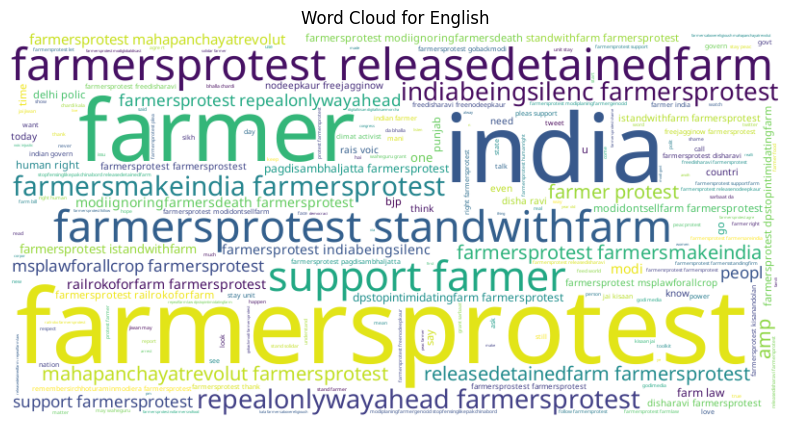

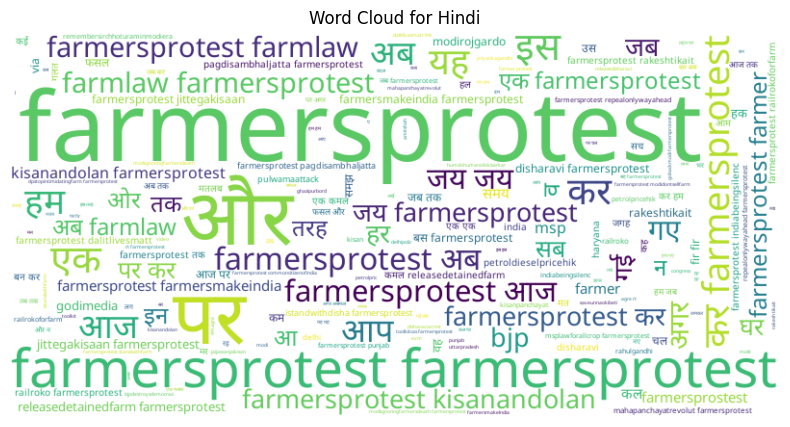

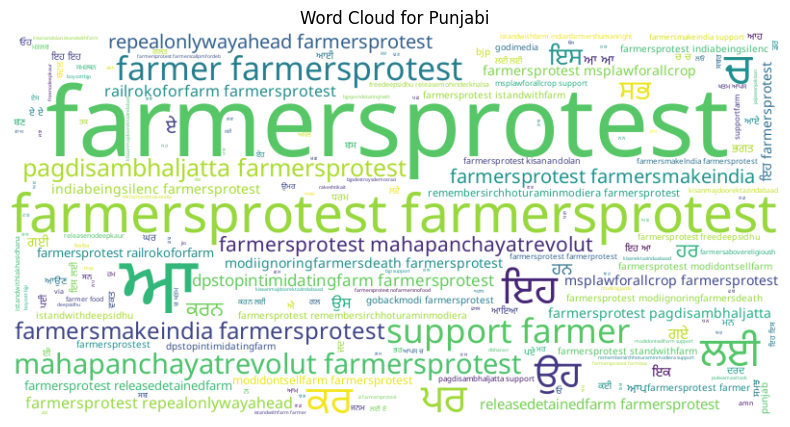

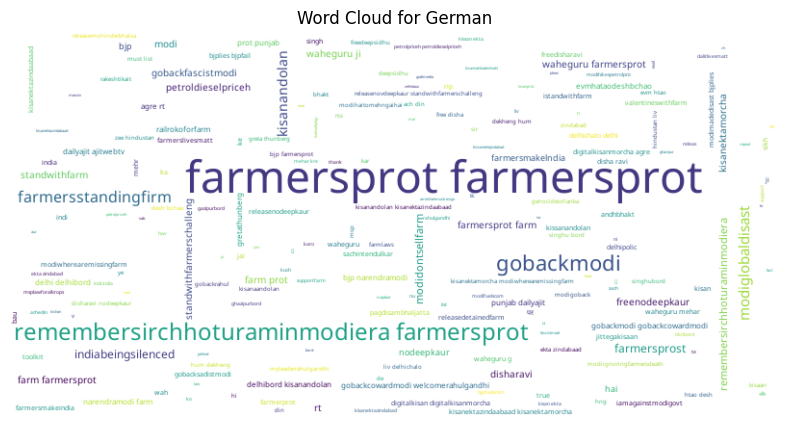

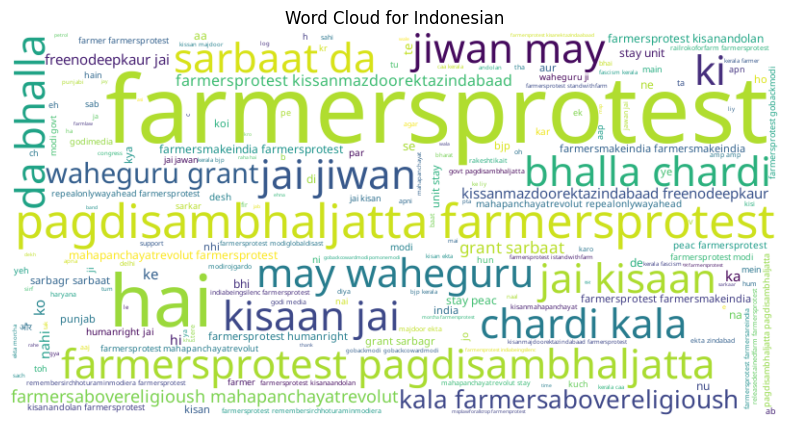

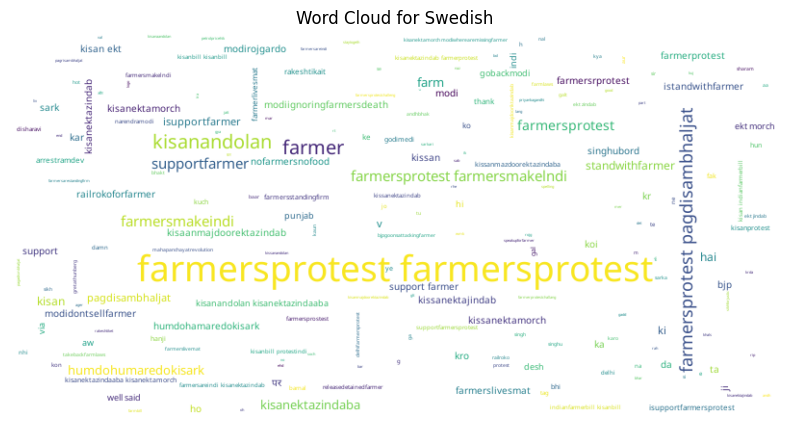

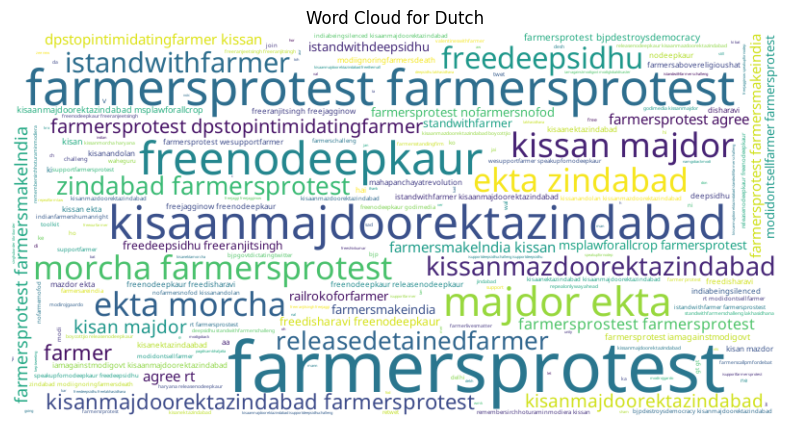

In [19]:
# path to the font files for different languages
font_paths = {
    'hindi': "./Fonts/NotoSansDevanagari.ttf",
    'punjabi': "./Fonts/NotoSansGurmukhi.ttf",
    'latin': "./Fonts/NotoSans.ttf"
}

languages = top_7_languages[top_7_languages['language'] != 'others']['language'].tolist()

# word cloud for each of the top 7 languages used in the tweets
for lang in languages:
    text = ' '.join(df[df['language'] == lang]['content'].tolist())

    # choose font based on the language as some languages have special characters
    if lang == 'hindi':
        font_path = font_paths['hindi']
    elif lang == 'punjabi':
        font_path = font_paths['punjabi']
    else:
        font_path = font_paths['latin']

    language = lang_map.get(lang, lang)

    wordcloud = WordCloud(font_path=font_path, width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {language.capitalize()}')

    # save word cloud as a PNG file
    # filename = f"./WordCloud_{language.capitalize()}.png"
    # plt.savefig(filename, format='png', bbox_inches='tight', pad_inches=0)

    plt.show()

    plt.close()
